# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
rows, cols = azdias.shape
print(rows, cols)

#Here we can see the 900k people by 85 feature columns
azdias.head()


891221 85


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
#Here we can see a resume of the 85 features by 4 columns
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values and convert them to NaNs.
# get column names
azdias_columns = azdias.columns
#getting the list values by each row in the missing_or_unknown column
missing_or_unknown = feat_info['missing_or_unknown']
feat_info_attributes = feat_info['attribute']
missing_or_unknown = missing_or_unknown.apply(lambda x: x[1:-1].split(','))

#saving azdias in aux value, cause I'll modify the auxiliar value instead of the original
azdias_aux = azdias

In [8]:
for attr, missing_list in zip(feat_info_attributes, missing_or_unknown):
    if missing_list[0] != '': # because some list have nothing to compare against
        for code in missing_list:
            if code.isnumeric() or code.lstrip('-').isnumeric():
                code = int(code)
            azdias_aux.loc[azdias_aux[attr] == code, attr] = np.nan

In [9]:
# saving azdias data cleaned from unknown data
azdias_aux.to_csv('azdiaz_w_nans.csv', sep=';', index = False)

In [10]:
#azdias = pd.read_csv('azdiaz_w_nans.csv', delimiter=';')

In [11]:
azdias = azdias_aux
azdias.head(35)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1.0,3.0,3.0,3.0,4.0,1.0,3.0,2.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1.0,3.0,4.0,4.0,2.0,4.0,2.0,2.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2.0,4.0,2.0,4.0,2.0,3.0,5.0,4.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
nan_values_by_column = azdias.isnull().sum()
nan_pct_by_column = nan_values_by_column[nan_values_by_column > 0] * 100 / (azdias.shape[0])

nan_pct_by_column.sort_values(ascending=False)

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

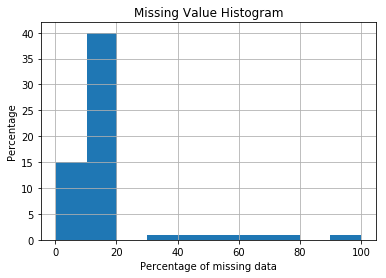

In [13]:
# Investigate patterns in the amount of missing data in each column.
nan_pct_by_column.sort_values(inplace=True)
plt.hist(nan_pct_by_column)
plt.xlabel('Percentage of missing data')
plt.ylabel('Percentage')
plt.title('Missing Value Histogram')
plt.grid(True)
plt.show()

- In this histogram we can appreciate the distribution of our error. This histogram can give great insights into which columns have the most Nans and therefore we can avoid them in order to train dataset in future steps.


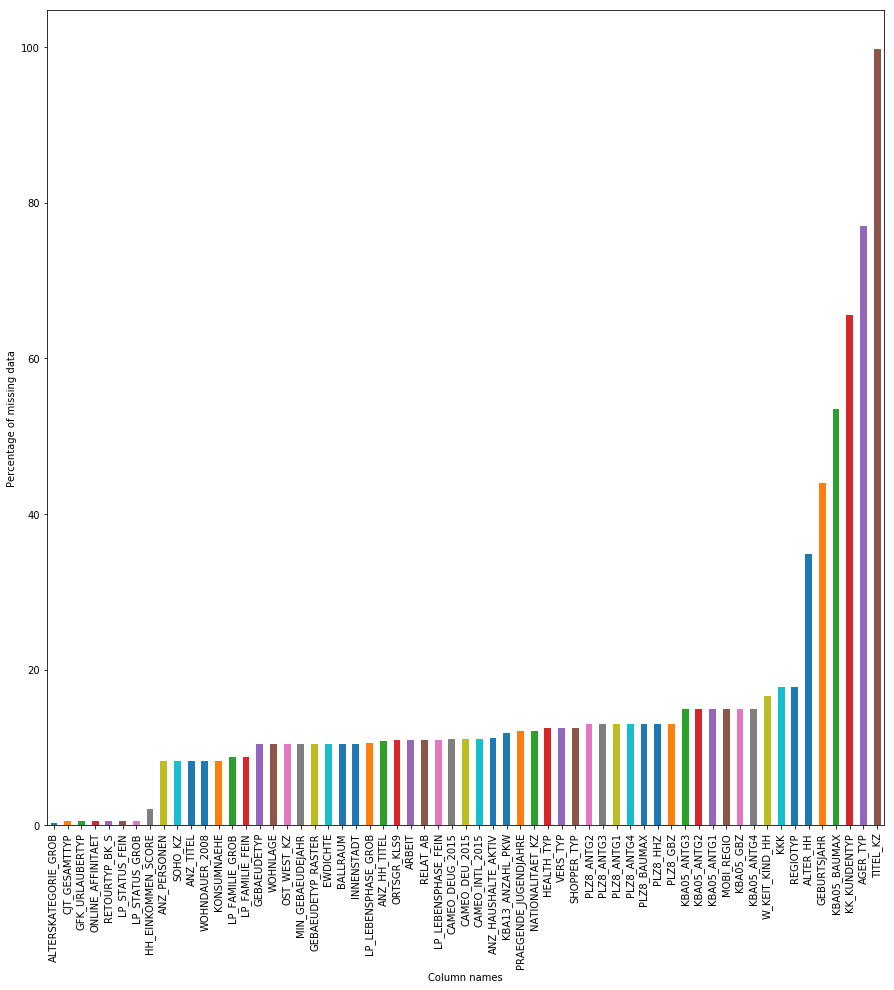

In [14]:
nan_pct_by_column.plot.bar(figsize=(15,15))
plt.xlabel('Column names')
plt.ylabel('Percentage of missing data')
plt.show()

In [15]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
#getting processed data from storage
#azdias = pd.read_csv('azdiaz_w_nans.csv', delimiter=';')
percentage = 25
outliers = nan_pct_by_column[nan_pct_by_column > percentage]

for col_name in outliers.index:
    azdias.drop(col_name, axis=1, inplace=True)

In [16]:
azdias.shape

(891221, 79)

In [17]:
outliers

ALTER_HH        34.813699
GEBURTSJAHR     44.020282
KBA05_BAUMAX    53.468668
KK_KUNDENTYP    65.596749
AGER_TYP        76.955435
TITEL_KZ        99.757636
dtype: float64

#### Discussion 1.1.2: Assess Missing Data in Each Column

First I stored the features attributes and general demographics data into auxiliary variables in order not to lose them. Second I processed each column in the demmographics data and replaced with __Nan__ the values that were in the __missing_or_unknown__ colum from the feature attributes. Third I stored the proccesed data into a file, in order to save runtime. And fourth I displayed an histogram and a ranking of nana percentage values by column.

I realized that each column has missing data some more than others, In the first histogram we can appreciate that the mean missing data was by the 40% and in the bar graph we can appreciate how there is a big gap between the columns __ALTER_HH__ and __REGIOTYP__ there is a separation of almost 15% so it would be a good option to concider that the columns with more than 25% are our outliers. Thus avoiding training potential misleading. data.

The removed colums are 6: __ALTER_HH__, __GEBURTSJAHR__, __KK_KUNDENTYP__, __AGER_TYP__, __TITEL_KZ__. Once removing the outlier columns our data has only 79 colums with few missing data.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [18]:
# How much data is missing in each row of the dataset?
nan_values_by_row = azdias.isnull().sum(axis=1)
nan_pct_by_row = nan_values_by_row / azdias.shape[1] * 100

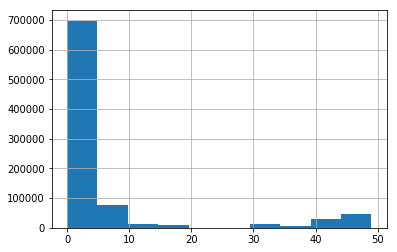

In [19]:
azdias.isnull().sum(axis=1).sort_values(ascending=False).hist()

In [20]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold = 20 #this value was suggested in the previous submission
subset_A = azdias.iloc[[i for i in nan_values_by_row[nan_values_by_row < threshold].index]].reset_index(drop=True)
subset_B = azdias.iloc[[i for i in nan_values_by_row[nan_values_by_row >= threshold].index]].reset_index(drop=True)
print(subset_A.shape)
print(subset_B.shape)

(797077, 79)
(94144, 79)


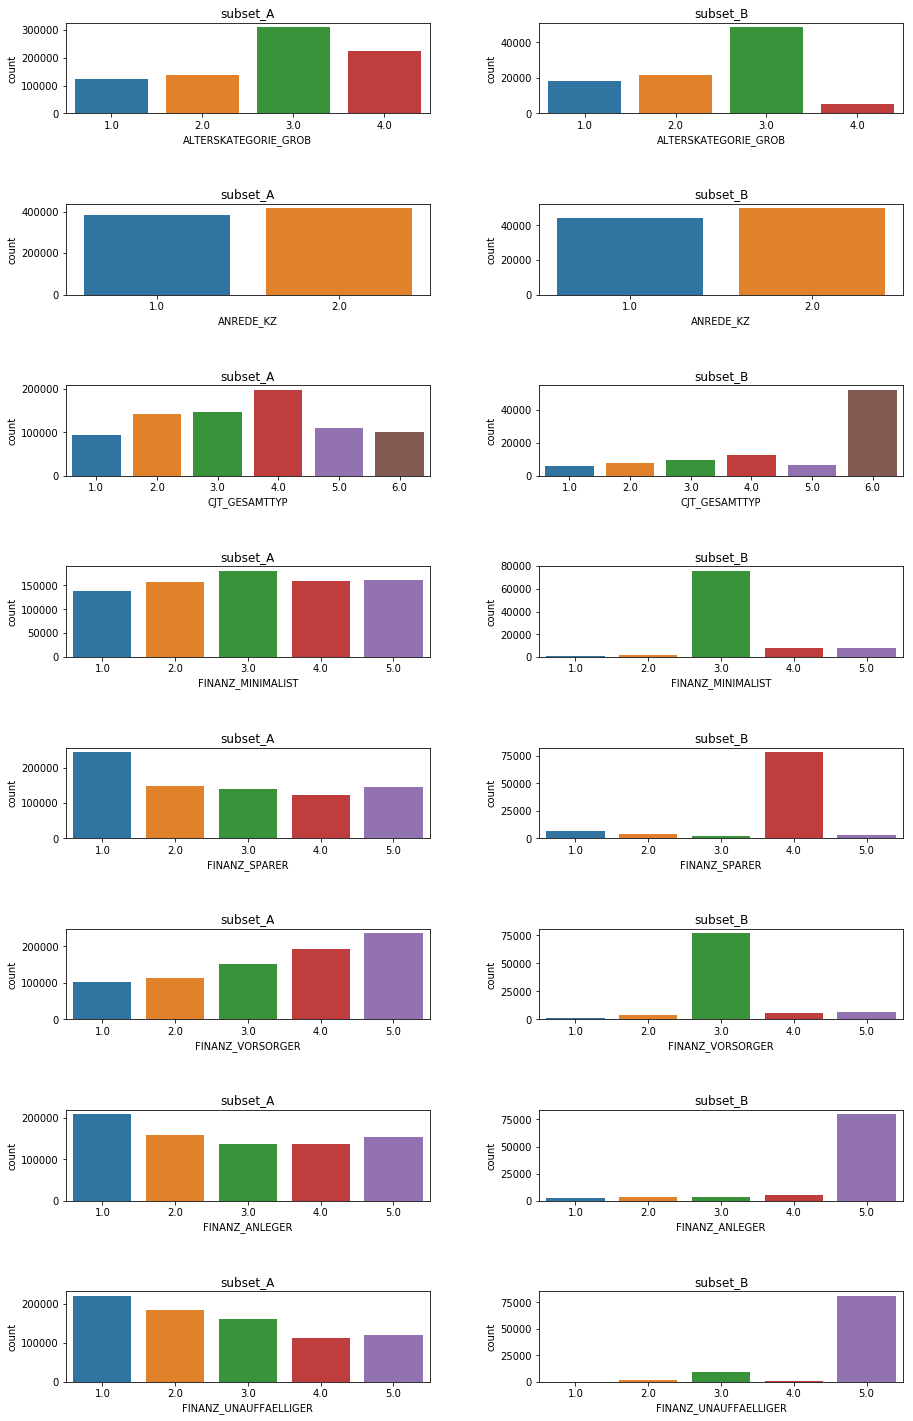

In [21]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def plot_countplot(cols, num):
    fig, axs = plt.subplots(num, 2, figsize=(15, 25))
    fig.subplots_adjust(hspace=1, wspace=0.3)
    axs = axs.ravel()
    for col in range(num):
        
        sns.countplot(subset_A[cols[col]], ax=axs[col*2])
        axs[col*2].set_title('subset_A')
        
        sns.countplot(subset_B[cols[col]], ax=axs[col*2+1])
        axs[col*2+1].set_title('subset_B')

plot_countplot(azdias.columns, 8)

In [22]:
pct_insubset_B = subset_B.shape[0] / azdias.shape[0] * 100
pct_insubset_B

10.563485375681228

In [23]:
pct_insubset_A = subset_A.shape[0] / azdias.shape[0] * 100
pct_insubset_A

89.43651462431878

#### Discussion 1.1.3: Assess Missing Data in Each Row

In the first histogram of this section it is possible to appreciate a contrast of missing words by row. Most rows have less than 5% of missing data. After dividing the data into two subsets __subset_A__ and __subset_B__. __subset_A__ consist of rows which have less than 20 Nan values per row and __subset_B__ consist of rows who have more or equal than 20 Nan values per row.

By watching to the subset comparison of distributions it is clearly to see that __subset_B__ has 10.56% of the data and __subset_A__ 89.43%. Therefore if we chose __subset_A__ we are going to be working with almost no missing data.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [24]:
# How many features are there of each data type?
#feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
feat_info.type.value_counts()


ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [25]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
# binary
for attribute in feat_info[feat_info['type']=='categorical'].attribute:
    if attribute in azdias.columns:
        if azdias[attribute].nunique() == 2:
            print(attribute, azdias[attribute].unique())

ANREDE_KZ [ 1.  2.]
GREEN_AVANTGARDE [0 1]
SOHO_KZ [ nan   1.   0.]
VERS_TYP [ nan   2.   1.]
OST_WEST_KZ [nan 'W' 'O']


In [26]:
azdias['OST_WEST_KZ'].unique()

array([nan, 'W', 'O'], dtype=object)

In [27]:
# Re-encode categorical variable(s) to be kept in the analysis.
subset_A = pd.get_dummies(subset_A, columns=['OST_WEST_KZ'])

In [28]:
subset_A['OST_WEST_KZ_W'].unique()

array([1, 0], dtype=uint64)

In [29]:
# already droped
drop_columns = list(outliers.index)
drop_columns

['ALTER_HH',
 'GEBURTSJAHR',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'AGER_TYP',
 'TITEL_KZ']

In [30]:
# multilevel
for attribute in feat_info[feat_info['type']=='categorical'].attribute:
    if attribute in subset_A.columns:
        if subset_A[attribute].nunique() > 2:
            subset_A.drop(attribute, axis='columns', inplace=True)
            drop_columns.append(attribute)

In [31]:
# need to be re-encoded
drop_columns

['ALTER_HH',
 'GEBURTSJAHR',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'AGER_TYP',
 'TITEL_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [32]:
subset_A.shape

(797077, 67)

In [33]:
subset_A.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_ANTG1',
       'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM',
       'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_

#### Discussion 1.2.1: Re-Encode Categorical Features

Regarding categorical variblaes. I decided to drop all multi level variables, I keep all binary variables and re-encode __OST_WEST_KZ__ because it was a non-numeric binary variable.


List of dropped variables:
['ALTER_HH',
 'GEBURTSJAHR',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'AGER_TYP',
 'TITEL_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']
 
 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [34]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# 0: Mainstream
# 1: Avantgarde
movement = {
    1: [40,0],
    2: [40,1],
    3: [50,0],
    4: [50,1],
    5: [60,0],
    6: [60,1],
    7: [60,1],
    8: [70,0],
    9: [70,1],
    10: [80,0],
    11: [80,1],
    12: [80,0],
    13: [80,1],
    14: [90,0],
    15: [90,1],
    np.nan: [np.nan, np.nan]
}


In [35]:
#updating values
subset_A['GENERATION'] = subset_A['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: np.nan if np.isnan(x) else movement[x][0])


In [36]:
#updating values
subset_A['MOVEMENT'] = subset_A['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: np.nan if np.isnan(x) else movement[x][1])


In [37]:
subset_A['CAMEO_INTL_2015'].unique()

array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', nan, '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

In [38]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Map the wealth level
subset_A['WEALTH'] = subset_A['CAMEO_INTL_2015'].apply(lambda x: np.nan if np.isnan(float(x)) else int(str(x)[0]))
# Map the life stage
subset_A['LIFESTAGE'] = subset_A['CAMEO_INTL_2015'].apply(lambda x: np.nan if np.isnan(float(x)) else int(str(x)[0]))


In [39]:
subset_A.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,GENERATION,MOVEMENT,WEALTH,LIFESTAGE
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,4.0,3.0,5.0,4.0,0,1,90.0,0.0,5.0,5.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,4.0,3.0,5.0,2.0,0,1,90.0,1.0,2.0,2.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,4.0,2.0,3.0,3.0,0,1,70.0,0.0,1.0,1.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,3.0,4.0,6.0,5.0,0,1,70.0,0.0,4.0,4.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,5.0,2.0,3.0,3.0,0,1,50.0,0.0,5.0,5.0


In [40]:
for attribute in feat_info[feat_info['type']=='mixed'].attribute:
    # dropping colum
    if attribute in subset_A.columns:
        subset_A.drop(attribute, axis='columns', inplace=True)

In [41]:
subset_A.shape

(797077, 65)

#### Discussion 1.2.2: Engineer Mixed-Type Features

The PRAEGENDE_JUGENDJAHRE parameter was dropped and engineered into two: GENERATION and MOVEMENT.

About the CAMEO_INTL_2015 parameter was dropped and engineered into two: WEALTH and LIFESTAGE.

Finally, Dropped all mixed type features. Because to dummy encode all of them would take more time than expected.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [42]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)


In [43]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [44]:
# encode for PRAEGENDE_JUGENDJAHRE column
movement = {
    1: [40,0],
    2: [40,1],
    3: [50,0],
    4: [50,1],
    5: [60,0],
    6: [60,1],
    7: [60,1],
    8: [70,0],
    9: [70,1],
    10: [80,0],
    11: [80,1],
    12: [80,0],
    13: [80,1],
    14: [90,0],
    15: [90,1],
    np.nan: [np.nan, np.nan]
}

def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    # Identify missing or unknown data values and convert them to NaNs.
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
    feat_info_attributes = feat_info['attribute']
    missing_or_unknown = feat_info['missing_or_unknown']
    missing_or_unknown = missing_or_unknown.apply(lambda x: x[1:-1].split(','))
    
    for attr, missing_list in zip(feat_info_attributes, missing_or_unknown):
        if missing_list[0] != '':
            for code in missing_list:
                if code.isnumeric() or code.lstrip('-').isnumeric():
                    code = int(code)
                df.loc[df[attr] == code, attr] = np.nan
    
    # remove selected columns and rows, ...
    drop_columns = ['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP', 'TITEL_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN' 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    for column in drop_columns:
        if column in df.columns:
            df.drop(column, axis=1, inplace=True)
            
    # 2. remove rows
    nan_values_by_row = df.isnull().sum(axis=1)
    df = df.iloc[[i for i in nan_values_by_row[nan_values_by_row < 20].index]].reset_index(drop=True)
    
    # select, re-encode, and engineer column values.
    if 'OST_WEST_KZ' in df.columns:
        df = pd.get_dummies(df, columns=['OST_WEST_KZ'])
        
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        df['GENERATION'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: np.nan if np.isnan(x) else movement[x][0])
        df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: np.nan if np.isnan(x) else movement[x][1])
        df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    if 'CAMEO_INTL_2015' in df.columns:
        df['WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: np.nan if np.isnan(float(x)) else int(str(x)[0]))
        df['LIFESTAGE'] = df['CAMEO_INTL_2015'].apply(lambda x: np.nan if np.isnan(float(x)) else int(str(x)[0]))
        df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
        
    #drop other columns
    for attribute in feat_info[feat_info['type']=='mixed'].attribute:
        if attribute in df.columns:
            df.drop(attribute, axis='columns', inplace=True)
            
    # Return the cleaned dataframe.
    return df
    
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [45]:
new_azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

In [46]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

new_azdias = clean_data(new_azdias)

In [47]:
imputer = Imputer(missing_values=np.nan, strategy="median")
new_azdias = imputer.fit_transform(new_azdias)

In [48]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
new_azdias = scaler.fit_transform(new_azdias)


### Discussion 2.1: Apply Feature Scaling

Used imputer in order to fill missing data with median value and standardscaler from sklearn library for feature scaling.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [49]:
# Apply PCA to the data.
pca1 = PCA()
model = pca1.fit_transform(new_azdias)

In [50]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


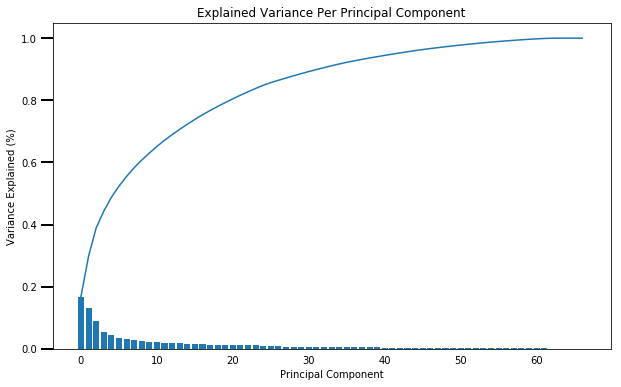

In [51]:
scree_plot(pca1)

In [52]:
for i in np.arange(15, len(pca1.explained_variance_ratio_), 15):
    print('For {} components, explained variance:'.format(i), 
          pca1.explained_variance_ratio_[:i].sum())

For 15 components, explained variance: 0.722861983043
For 30 components, explained variance: 0.885902260513
For 45 components, explained variance: 0.959961658417
For 60 components, explained variance: 0.996433044679


In [53]:
# Re-apply PCA to the data while selecting for number of components to retain.
from sklearn.decomposition import PCA

pca2 = PCA(n_components=30)
azdias_pca = pca2.fit_transform(new_azdias)

In [54]:
pca2.explained_variance_ratio_.sum()

0.88582750834183732

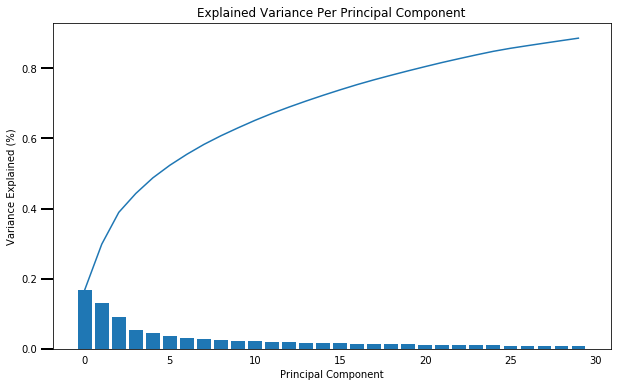

In [55]:
scree_plot(pca2)

### Discussion 2.2: Perform Dimensionality Reduction


Once seen que explained variance by principal component. The first comoonent captures almost 20 percent of the total variability in the data, with 30 components we capture 88.59% of the variability. So I will retain these 30 components for the upcoming step. I could chooose more components, but at 30 components we have agood amont of the total amount of variability explained.


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [56]:
df = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
df = clean_data(df)

In [57]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.


def show_weight(full_dataset, pca, comp_n, feat_n):
    components = pd.DataFrame(np.round(pca.components_, 4), columns=full_dataset.keys()).iloc[comp_n - 1]
    components.sort_values(ascending=False, inplace=True)
    top2n_components = pd.concat([components.head(feat_n), components.tail(feat_n)])
    top2n_components.plot(kind='bar', 
                          title='Top {} weighted features for PCA component {}'.format(feat_n*2, comp_n), 
                          figsize=(12, 6))
    plt.show()
    return components



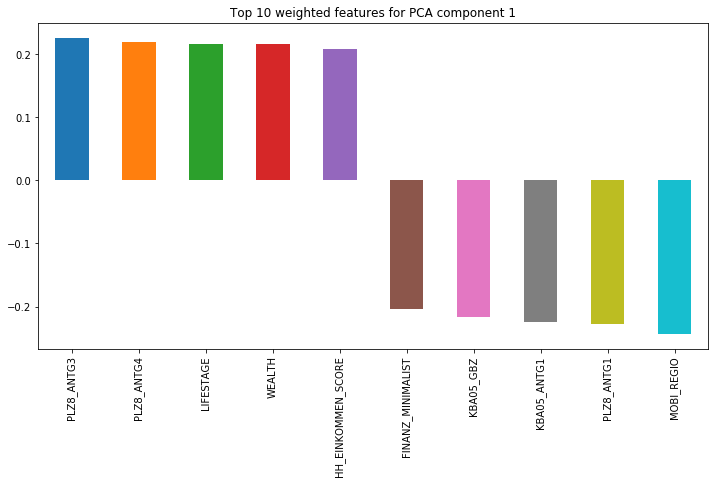

PLZ8_ANTG3               0.2264
PLZ8_ANTG4               0.2190
LIFESTAGE                0.2160
WEALTH                   0.2160
HH_EINKOMMEN_SCORE       0.2077
ORTSGR_KLS9              0.1954
EWDICHTE                 0.1932
FINANZ_HAUSBAUER         0.1708
KBA05_ANTG4              0.1568
PLZ8_ANTG2               0.1539
ARBEIT                   0.1479
KBA05_ANTG3              0.1388
ANZ_HAUSHALTE_AKTIV      0.1385
RELAT_AB                 0.1363
FINANZ_SPARER            0.1148
SEMIO_PFLICHT            0.0859
SEMIO_REL                0.0828
SEMIO_RAT                0.0699
REGIOTYP                 0.0685
GENERATION               0.0672
OST_WEST_KZ_O            0.0621
SEMIO_TRADV              0.0598
SEMIO_MAT                0.0597
SEMIO_FAM                0.0588
W_KEIT_KIND_HH           0.0568
SEMIO_KULT               0.0497
FINANZ_ANLEGER           0.0451
SEMIO_KAEM               0.0446
FINANZ_UNAUFFAELLIGER    0.0439
KKK                      0.0405
                          ...  
ANREDE_K

In [58]:
components1 = show_weight(df, pca2, 1, 5)
components1

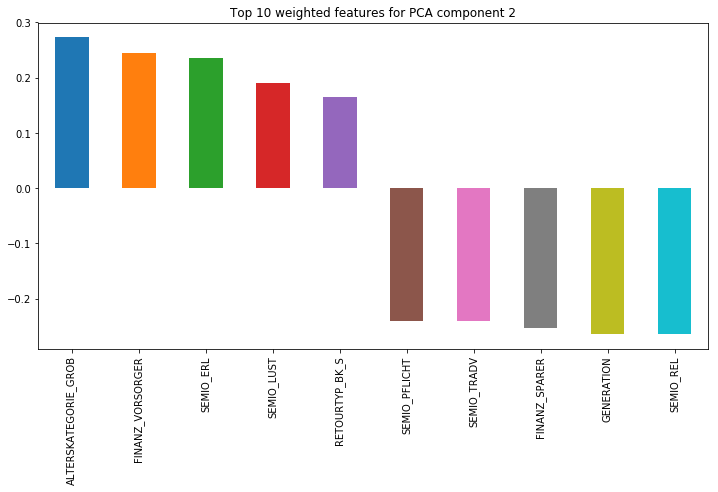

ALTERSKATEGORIE_GROB     0.2728
FINANZ_VORSORGER         0.2447
SEMIO_ERL                0.2351
SEMIO_LUST               0.1906
RETOURTYP_BK_S           0.1649
W_KEIT_KIND_HH           0.1227
SEMIO_KRIT               0.1119
SEMIO_KAEM               0.1002
FINANZ_MINIMALIST        0.0956
FINANZ_HAUSBAUER         0.0945
ANREDE_KZ                0.0836
WOHNDAUER_2008           0.0646
SEMIO_DOM                0.0621
EWDICHTE                 0.0587
ORTSGR_KLS9              0.0573
PLZ8_ANTG3               0.0566
PLZ8_ANTG4               0.0534
WEALTH                   0.0480
KBA05_ANTG4              0.0480
LIFESTAGE                0.0480
ARBEIT                   0.0457
RELAT_AB                 0.0431
ANZ_HAUSHALTE_AKTIV      0.0426
PLZ8_ANTG2               0.0394
HH_EINKOMMEN_SCORE       0.0309
KBA05_ANTG3              0.0269
VERS_TYP                 0.0265
ANZ_HH_TITEL             0.0251
OST_WEST_KZ_O            0.0199
REGIOTYP                 0.0083
                          ...  
OST_WEST

In [59]:
components2 = show_weight(df, pca2, 2, 5)
components2

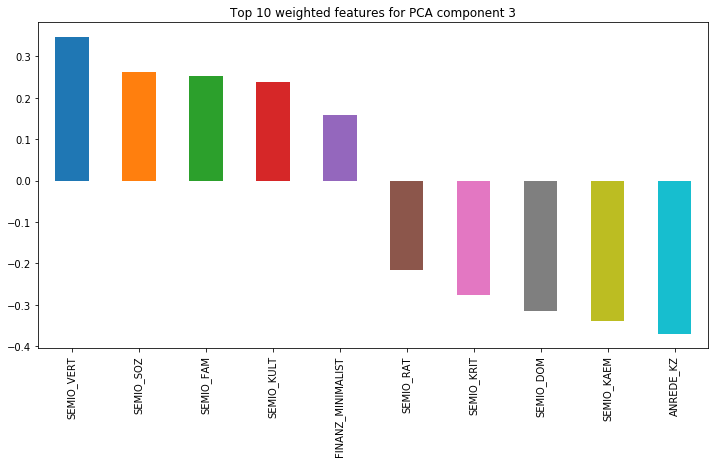

SEMIO_VERT               0.3467
SEMIO_SOZ                0.2626
SEMIO_FAM                0.2518
SEMIO_KULT               0.2377
FINANZ_MINIMALIST        0.1583
RETOURTYP_BK_S           0.1059
FINANZ_VORSORGER         0.0982
W_KEIT_KIND_HH           0.0936
ALTERSKATEGORIE_GROB     0.0768
SEMIO_REL                0.0721
SEMIO_LUST               0.0623
SEMIO_MAT                0.0577
GREEN_AVANTGARDE         0.0461
MOVEMENT                 0.0461
ORTSGR_KLS9              0.0375
PLZ8_ANTG4               0.0374
PLZ8_ANTG3               0.0368
EWDICHTE                 0.0365
WOHNDAUER_2008           0.0309
ARBEIT                   0.0309
RELAT_AB                 0.0263
LIFESTAGE                0.0244
WEALTH                   0.0244
PLZ8_ANTG2               0.0240
KBA05_ANTG4              0.0232
ANZ_HAUSHALTE_AKTIV      0.0211
OST_WEST_KZ_O            0.0175
ANZ_HH_TITEL             0.0115
ANZ_TITEL                0.0090
KBA05_ANTG3              0.0065
                          ...  
MIN_GEBA

In [60]:
components3 = show_weight(df, pca2, 3, 5)
components3

### Discussion 2.3: Interpret Principal Components

    Can we interpret positive and negative values from them in a meaningful way?)
 
    From the first principal component:

we could interpret that there is an opposite relation between the number of family houses PLZ8 region and the family shared houses in the microcell region, we could assume that there is a wealth gap between those regions.


    From the second principal component:

From this I could interpret that these is an inverse correlation in the consumer pattern between people that are separated by their generational data, for example personality and generation could affect consumer patterns.


    From the third principal component:

By watching to this results. We could say that the persoanilty topology was calculated based on each consumer data and that we could use this component in order to get better insights if we want to make marketing campaigns aiming to an specific gender.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [61]:
# Over a number of different cluster counts...
n_clusters = np.arange(1, 15)
distances = []

for n_cluster in n_clusters:
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=n_cluster)
    print('Fitting k = {} '.format(n_cluster))
    model = kmeans.fit_predict(azdias_pca)
    pred_centroids = kmeans.cluster_centers_
    centers = pred_centroids[model]
    # compute the average within-cluster distances.
    distance = np.sqrt(((azdias_pca - centers) ** 2).sum(axis = 1)).mean()
    distances.append(distance)
 

Fitting k = 1 
Fitting k = 2 
Fitting k = 3 
Fitting k = 4 
Fitting k = 5 
Fitting k = 6 
Fitting k = 7 
Fitting k = 8 
Fitting k = 9 
Fitting k = 10 
Fitting k = 11 
Fitting k = 12 
Fitting k = 13 
Fitting k = 14 


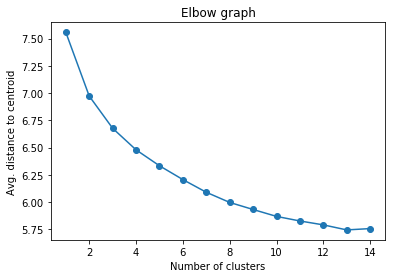

In [62]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(n_clusters, distances, '-o')
plt.ylabel('Avg. distance to centroid')
plt.xlabel('Number of clusters')
plt.title('Elbow graph');

In [63]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=9)
general_model = kmeans.fit(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

In order to decide how many clusters I used had to use the elbow method which compares the average distance of each point to the cluster center of diferent number of centers. By looking at the elbow graph I decided to use 9 number of clasters, I could dig into more but due to computational challenges I'll leave it there.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [64]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter=";")
customers.shape

(191652, 85)

In [65]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customer_data_cleaned = clean_data(customers)

In [66]:
customer_data_cleaned.shape

(141630, 67)

In [67]:
customer_data_imp = imputer.transform(customer_data_cleaned)
customer_data_scaled = scaler.transform(customer_data_imp)
customer_data_scaled.shape

(141630, 67)

In [68]:
customers_pca = pca2.transform(customer_data_scaled)

In [69]:
customer_predictions = general_model.predict(customers_pca)

In [70]:
customer_predictions

array([5, 6, 7, ..., 5, 2, 7], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

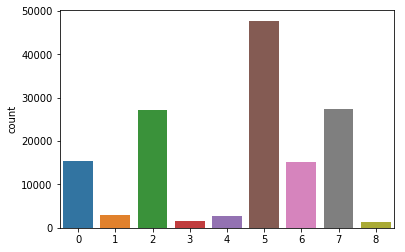

In [71]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
sns.countplot(customer_predictions)

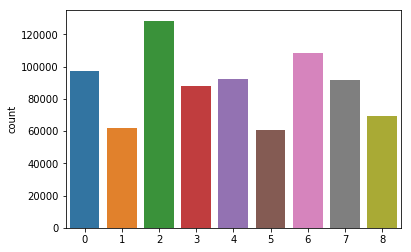

In [72]:
general_predictions = general_model.predict(azdias_pca)
sns.countplot(general_predictions)

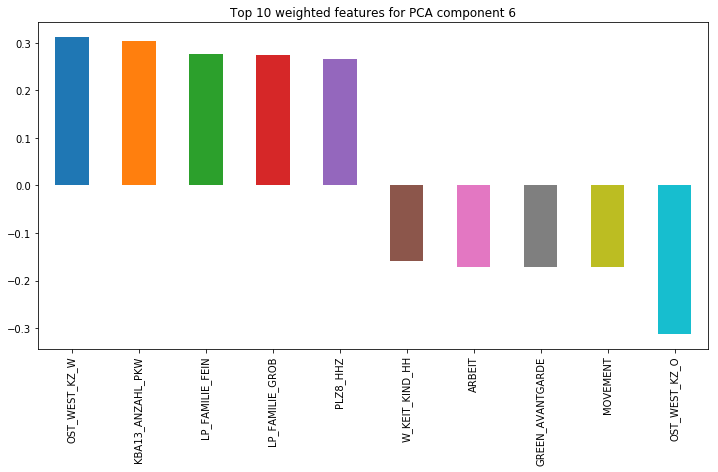

OST_WEST_KZ_W            0.3119
KBA13_ANZAHL_PKW         0.3034
LP_FAMILIE_FEIN          0.2774
LP_FAMILIE_GROB          0.2752
PLZ8_HHZ                 0.2657
ANZ_PERSONEN             0.2481
PLZ8_GBZ                 0.2185
REGIOTYP                 0.1899
KKK                      0.1765
HH_EINKOMMEN_SCORE       0.1385
LIFESTAGE                0.1204
WEALTH                   0.1204
PLZ8_ANTG2               0.1075
KBA05_ANTG3              0.1051
FINANZ_VORSORGER         0.1048
WOHNDAUER_2008           0.0888
INNENSTADT               0.0800
KBA05_ANTG2              0.0731
BALLRAUM                 0.0568
VERS_TYP                 0.0518
ALTERSKATEGORIE_GROB     0.0510
KBA05_ANTG4              0.0357
ONLINE_AFFINITAET        0.0353
SEMIO_LUST               0.0336
SEMIO_ERL                0.0331
RETOURTYP_BK_S           0.0301
PLZ8_ANTG3               0.0300
ANZ_HAUSHALTE_AKTIV      0.0299
GEBAEUDETYP_RASTER       0.0284
FINANZ_UNAUFFAELLIGER    0.0233
                          ...  
FINANZ_A

In [73]:
customer_scaled_df = pd.DataFrame(data = customer_data_scaled, columns = customer_data_cleaned.columns)

show_weight(customer_scaled_df, pca2, 6, 5)

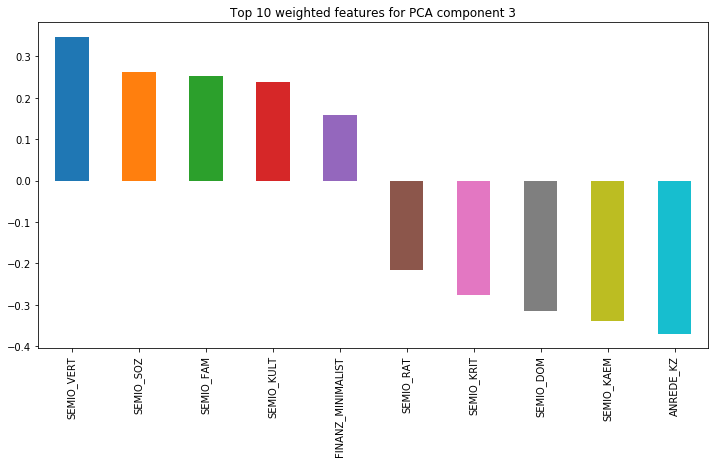

SEMIO_VERT               0.3467
SEMIO_SOZ                0.2626
SEMIO_FAM                0.2518
SEMIO_KULT               0.2377
FINANZ_MINIMALIST        0.1583
RETOURTYP_BK_S           0.1059
FINANZ_VORSORGER         0.0982
W_KEIT_KIND_HH           0.0936
ALTERSKATEGORIE_GROB     0.0768
SEMIO_REL                0.0721
SEMIO_LUST               0.0623
SEMIO_MAT                0.0577
GREEN_AVANTGARDE         0.0461
MOVEMENT                 0.0461
ORTSGR_KLS9              0.0375
PLZ8_ANTG4               0.0374
PLZ8_ANTG3               0.0368
EWDICHTE                 0.0365
WOHNDAUER_2008           0.0309
ARBEIT                   0.0309
RELAT_AB                 0.0263
LIFESTAGE                0.0244
WEALTH                   0.0244
PLZ8_ANTG2               0.0240
KBA05_ANTG4              0.0232
ANZ_HAUSHALTE_AKTIV      0.0211
OST_WEST_KZ_O            0.0175
ANZ_HH_TITEL             0.0115
ANZ_TITEL                0.0090
KBA05_ANTG3              0.0065
                          ...  
MIN_GEBA

In [75]:
show_weight(customer_scaled_df, pca2, 3, 5)

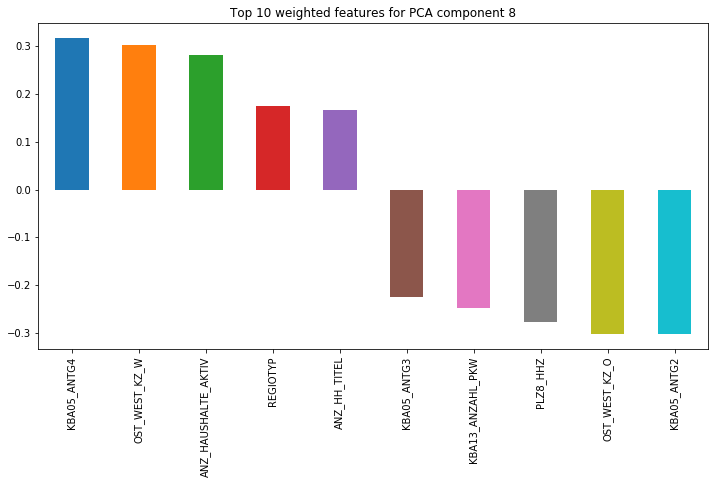

KBA05_ANTG4              0.3167
OST_WEST_KZ_W            0.3019
ANZ_HAUSHALTE_AKTIV      0.2806
REGIOTYP                 0.1755
ANZ_HH_TITEL             0.1670
KKK                      0.1392
PLZ8_ANTG1               0.1313
VERS_TYP                 0.1152
HEALTH_TYP               0.1020
KBA05_ANTG1              0.0696
EWDICHTE                 0.0651
FINANZ_UNAUFFAELLIGER    0.0605
SEMIO_PFLICHT            0.0534
FINANZ_VORSORGER         0.0526
ORTSGR_KLS9              0.0509
KONSUMNAEHE              0.0470
RETOURTYP_BK_S           0.0444
SEMIO_KRIT               0.0400
SEMIO_KULT               0.0344
SEMIO_KAEM               0.0261
SEMIO_REL                0.0252
ANZ_TITEL                0.0233
GENERATION               0.0231
SEMIO_SOZ                0.0212
FINANZ_MINIMALIST        0.0199
W_KEIT_KIND_HH           0.0153
FINANZ_SPARER            0.0146
SEMIO_DOM                0.0036
SOHO_KZ                  0.0019
WOHNDAUER_2008           0.0012
                          ...  
SEMIO_VE

In [81]:
show_weight(customer_scaled_df, pca2, 8, 5)

In [77]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?


#### Answer. 

THe 6th cluster is overrepresents in the customer data compared to the general population.
It seems that this cluster describes people with the following attributes: OST_WEST_KZ_W, KBA13_ANZAHL_PKW, LP_FAMILIE_FEIN, LP_FAMILIE_GROB and PLZ8_HHZ

In [84]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

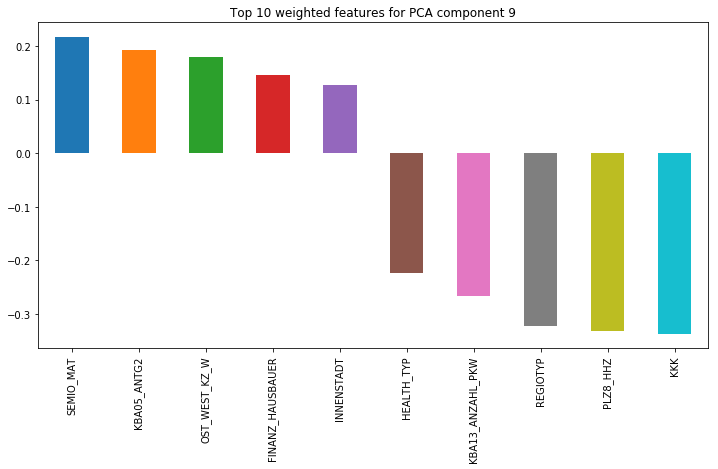

SEMIO_MAT               0.2166
KBA05_ANTG2             0.1925
OST_WEST_KZ_W           0.1799
FINANZ_HAUSBAUER        0.1467
INNENSTADT              0.1278
BALLRAUM                0.1146
KBA05_ANTG3             0.1080
PLZ8_ANTG2              0.1078
SEMIO_TRADV             0.1060
SEMIO_RAT               0.1000
LP_FAMILIE_FEIN         0.0903
FINANZ_VORSORGER        0.0902
LP_FAMILIE_GROB         0.0866
HH_EINKOMMEN_SCORE      0.0811
ANZ_PERSONEN            0.0783
ANZ_HH_TITEL            0.0735
WOHNDAUER_2008          0.0715
SEMIO_LUST              0.0698
ANZ_TITEL               0.0555
WEALTH                  0.0551
LIFESTAGE               0.0551
ANREDE_KZ               0.0505
SEMIO_REL               0.0371
SEMIO_FAM               0.0318
SEMIO_PFLICHT           0.0156
RETOURTYP_BK_S          0.0077
ALTERSKATEGORIE_GROB    0.0047
SOHO_KZ                 0.0035
ANZ_HAUSHALTE_AKTIV    -0.0014
SEMIO_DOM              -0.0027
                         ...  
SEMIO_VERT             -0.0214
KBA05_GB

In [85]:
show_weight(customer_scaled_df, pca2, 9, 5)

#### Answer. 
The 9th cluster is underrepresented in the customer data compared to the general population. It seems that this cluster describes people with the following attributes: SEMIO_MAT, KBA05_ANTG2, OST_WEST_KZ_W, FINANZ_HAUSBAUER, INNENSTADT

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

By looking at plotted data it could be said that the segments of customer that are relatively popular with the mail-order company are the ones that are in the clusters 3, 6 and 8. In the other hand the least relatively unpopular segments of customers are in the cluster 9, 5 and 5.


SEMIO_MAT: Personality typology.

KBA05_ANTG2: number of 3-5 family houses.

OST_WEST_KZ_W: East / West Germany.

FINANZ_HAUSBAUER: Financial typology.

INNENSTADT: Distance to city center.





About the least relatively unpopular customer segment we could say that their kind of people matches someone old living almost near to the center of the city where 3 or 5 families per house is common.




OST_WEST_KZ_W : East / West Germany.

KBA13_ANZAHL_PKW: Number of cars in the PLZ8 region.

LP_FAMILIE_FEIN: Family type, fine scale.

LP_FAMILIE_GROB: Family type, rough scale.

PLZ8_HHZ: Number of households within the PLZ8 region.



And finally the most relatively popular customer segment we could say that their kind of people matches someone who lives in the PLZ8 region in a relatively young family.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.